In [1]:
!pip install --quiet evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but yo

In [2]:
import io
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from huggingface_hub import notebook_login

from datasets import load_dataset, DatasetDict

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

2025-06-11 12:35:18.688712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749645318.878479      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749645318.934212      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
notebook_login()

In [4]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
dataset = load_dataset("enterprise-explorers/oxford-pets")

README.md:   0%|          | 0.00/565 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

data/train-00000-of-00001-ecc2afb43dedd5(…):   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7390 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 7390
    })
})

In [6]:
dataset['train'][0]

{'path': '/data/datasets/magic-ml/oxford-iiit-pet/images/Siamese_137.jpg',
 'label': 'Siamese',
 'dog': False,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=345x500>}

In [7]:
labels = dataset['train'].unique('label')
print(len(labels),labels)

37 ['Siamese', 'Birman', 'shiba inu', 'staffordshire bull terrier', 'basset hound', 'Bombay', 'japanese chin', 'chihuahua', 'german shorthaired', 'pomeranian', 'beagle', 'english cocker spaniel', 'american pit bull terrier', 'Ragdoll', 'Persian', 'Egyptian Mau', 'miniature pinscher', 'Sphynx', 'Maine Coon', 'keeshond', 'yorkshire terrier', 'havanese', 'leonberger', 'wheaten terrier', 'american bulldog', 'english setter', 'boxer', 'newfoundland', 'Bengal', 'samoyed', 'British Shorthair', 'great pyrenees', 'Abyssinian', 'pug', 'saint bernard', 'Russian Blue', 'scottish terrier']


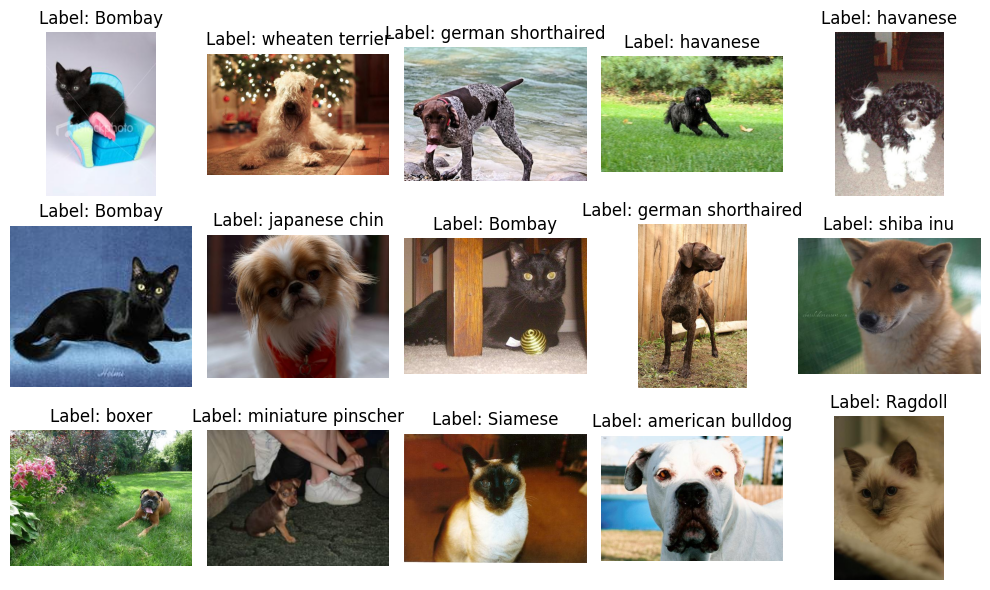

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

def show_samples(ds, rows, cols):
    samples = ds.shuffle(seed=42).select(range(rows * cols))
    fig = plt.figure(figsize=(cols * 2, rows * 2))

    for i in range(rows * cols):
        img = samples[i]['image']  # এটা ই হলো JpegImageFile
        label = samples[i]['label']

        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_title(f"Label: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# ব্যবহার:
show_samples(dataset['train'], rows=3, cols=5)


In [9]:
split_dataset = dataset['train'].train_test_split(test_size=0.2) # 80% train, 20% evaluation
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5) # 50% validation, 50% test

# recombining the splits using a DatasetDict

our_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})

our_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 5912
    })
    validation: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
})

In [10]:

label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}


In [11]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [30]:
from PIL import Image
import io

def transforms(batch):
    # Image decoding with type check
    images = []
    for x in batch['image']:
        if isinstance(x, dict) and 'bytes' in x:
            image = Image.open(io.BytesIO(x['bytes'])).convert('RGB')
        elif isinstance(x, Image.Image):
            image = x.convert('RGB')
        else:
            raise ValueError("Unsupported image format in batch.")
        images.append(image)

    inputs = processor(images, return_tensors='pt')
    inputs['labels'] = [label2id[y] for y in batch['label']]
    return inputs



In [31]:
processed_dataset = our_dataset.with_transform(transforms)

In [32]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [33]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

In [34]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [36]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

In [37]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,827,109 | trainable_params = 28,453


In [38]:
#!pip install --upgrade transformers


In [39]:
from transformers import TrainingArguments
print(TrainingArguments.__module__)


transformers.training_args


In [ ]:
!pip install transformers==4.40.0


In [50]:
import transformers
print(transformers.__version__)

4.51.3


In [40]:
import wandb

In [41]:
wandb.login(key="a4398f8247db3054c1748bb7e5846222f798f174")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [42]:
wandb.init(project="Computer Vision model Fintune")

In [43]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./vit-base-oxford-iiit-pets",
    per_device_train_batch_size=16,
    save_strategy="epoch",
    eval_strategy="epoch",  # ✅ eval_strategy যোগ করা হয়েছে
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',
    load_best_model_at_end=True,
)



In [44]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"]
)

In [28]:
trainer

In [45]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.738900,0.419526,0.899865
2,0.300500,0.299730,0.916103
3,0.217800,0.264673,0.925575
4,0.192800,0.253343,0.932341
5,0.173400,0.249563,0.930988


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=925, training_loss=0.4048385053067594, metrics={'train_runtime': 455.0879, 'train_samples_per_second': 64.954, 'train_steps_per_second': 2.033, 'total_flos': 2.2913817801515827e+18, 'train_loss': 0.4048385053067594, 'epoch': 5.0})

In [46]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/rakib730/vit-base-oxford-iiit-pets/commit/f06f896354a1f0ac03ac4fcc85f85480726ab96f', commit_message='End of training', commit_description='', oid='f06f896354a1f0ac03ac4fcc85f85480726ab96f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/rakib730/vit-base-oxford-iiit-pets', endpoint='https://huggingface.co', repo_type='model', repo_id='rakib730/vit-base-oxford-iiit-pets'), pr_revision=None, pr_num=None)

In [1]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor(do_resize=True, size={"height": 224, "width": 224}, do_normalize=True)
processor.save_pretrained("vit-base-oxford-iiit-pets")


2025-06-11 14:11:03.072074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749651063.247533      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749651063.301199      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['vit-base-oxford-iiit-pets/preprocessor_config.json']

In [2]:
import shutil

shutil.make_archive("vit-processor", 'zip', "vit-base-oxford-iiit-pets")


'/kaggle/working/vit-processor.zip'